In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

2024-04-02 03:32:21.343629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 03:32:21.343740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 03:32:21.519955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install -Uqq fastbook

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
df = pd.read_csv(r'../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()


,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

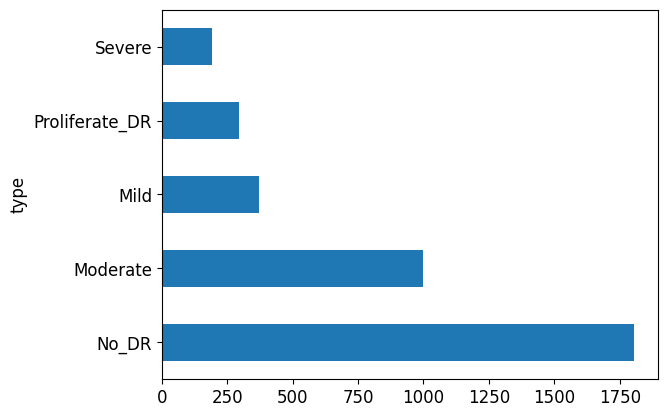

In [5]:
df['type'].value_counts().plot(kind='barh')

In [6]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['type'])
#train, test = train_test_split(df, test_size = 0.2, stratify = train_a['type'])

print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
print("For Testing Dataset :")
print(test['type'].value_counts(), '\n')

For Training Dataset :
type
No_DR             1444
Moderate           799
Mild               296
Proliferate_DR     236
Severe             154
Name: count, dtype: int64 

For Testing Dataset :
type
No_DR             361
Moderate          200
Mild               74
Proliferate_DR     59
Severe             39
Name: count, dtype: int64 



In [7]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
#val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

# if os.path.exists(val_dir):
#     shutil.rmtree(val_dir)
# os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [8]:
src_dir = r'../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index,row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

# for index, row in val.iterrows():
#     diagnosis = row['type']
#     binary_diagnosis = row['binary_type']
#     id_code = row['id_code'] + ".png"
#     srcfile = os.path.join(src_dir, diagnosis, id_code)
#     dstfile = os.path.join(val_dir, binary_diagnosis)
#     os.makedirs(dstfile, exist_ok = True)
#     shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

**RESNET**

In [9]:
train_path = 'train'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2929 images belonging to 2 classes.
Found 733 images belonging to 2 classes.


In [10]:
train_path=Path("/kaggle/working/train")
test_path=Path("/kaggle/working/test")

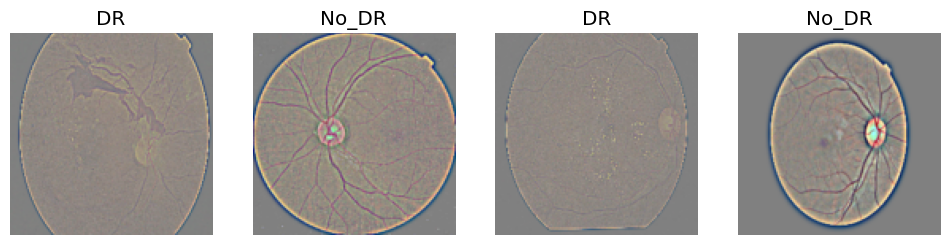

In [11]:
dc = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)
dls = dc.dataloaders(train_path)
dls.valid.show_batch(max_n=4,nrows=1)

In [12]:
learn = vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.495991,0.344567,0.094017,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.226912,0.204171,0.059829,00:06
1,0.131235,0.181997,0.054701,00:06
2,0.114682,0.279355,0.047863,00:06
3,0.078510,0.217584,0.044444,00:06
4,0.057563,0.203847,0.044444,00:06
5,0.037061,0.189381,0.046154,00:06
6,0.021656,0.203306,0.047863,00:06
7,0.013741,0.209455,0.049573,00:06


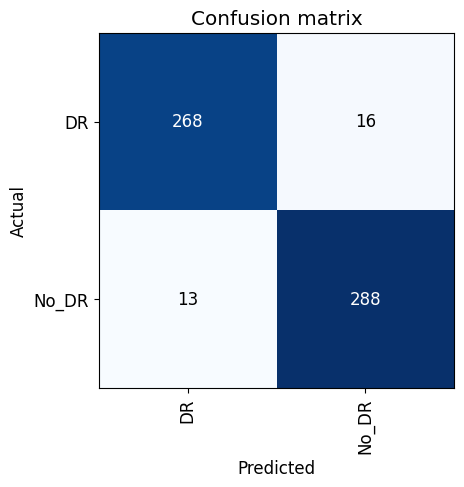

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [14]:
learn.export('/kaggle/working/stage-1_resnet.pkl')

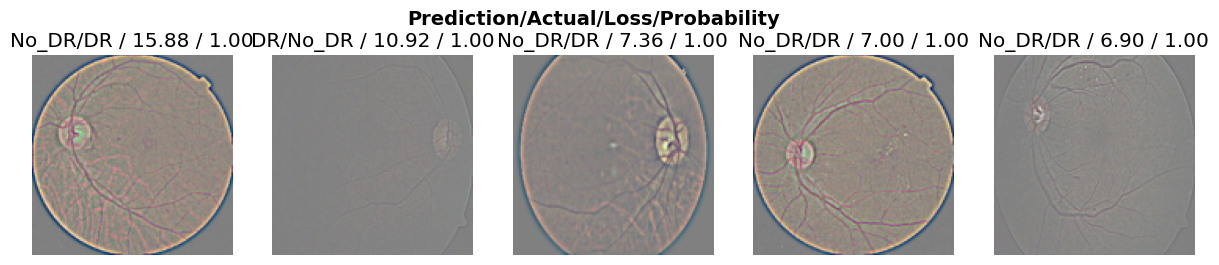

In [15]:
interp.plot_top_losses(5,nrows=1)

In [16]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [17]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [18]:
#learn = load_learner('path_to_model_directory')  # Load the pre-trained model

test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    #splitter=GrandparentSplitter(valid_name='test'),
    
    get_y=parent_label,
    item_tfms=Resize(224)
)


test_dl = test_db.dataloaders(test_path)
learn.test_dl = test_dl
results = learn.validate()
#print(f"loss:{results[0]}")
print(f"accuracy:{1-results[1]}")

accuracy:0.9504273496568203


In [19]:
def apply_gaussian_filter(image, sigmaX=10):
    # Applying Gaussian blur
    gaussian = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)
    return gaussian

In [20]:
pred,idx,probs = learn.predict(PILImage.create('/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/3088_right.jpeg'))
print(pred)
print(f"The probability of {pred} '{probs[idx]:.4f}'")

No_DR
The probability of No_DR '0.6190'


In [21]:
from IPython.display import FileLink 
FileLink(r'stage-1_resnet.pkl')

/kaggle/working/stage-1_resnet.pkl